# Linear Regression


An ecommerce retailer is looking to use machine learning to understand its customer's online engagement with its digital outlets i.e website and app. It is trying to decide whether to focus its efforts on the mobile app experience or website. We will use Linear Regression model to see which user acitivity has the biggest impact on their likelyhood of spending more money.

#### Variables of interest:
Avg. Session Length: Average session of in-store style advice sessions.<br>
Time on App: Average time spent on App in minutes <br>
Time on Website: Average time spent on Website in minutes <br>
Length of Membership: How many years the customer has been a member <br>

### Importing necesaary packages (including Snowpark)
If any of the packages do not exist in your Python environment you can install them using conda. Here is an example of installing seaborn visualization package

*import sys <br>
!conda install --yes --prefix {sys.prefix} seaborn*

In [67]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.functions import pandas_udf
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from snowflake.snowpark.functions import udf
%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns

Let us confirm our Snowflake enviornment

In [68]:
from snowflake.snowpark import Session
import json

with open('creds.json') as f:
    connection_parameters = json.load(f)    
session = Session.builder.configs(connection_parameters).create()

In [69]:
snowpark_version = VERSION
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Role                        : {}'.format(session.get_current_role()))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Database                    : "PYTHON_TESTING"
Schema                      : "PUBLIC"
Warehouse                   : "TINY_WAREHOUSE"
Role                        : "ACCOUNTADMIN"
Snowpark for Python version : 0.6.0


### Loading data from a local file into Pandas dataframe and then loading the data in Snowflake table

In [70]:
customers = pd.read_csv("~/Downloads/EcommerceCustomers")
customers.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [71]:
%%time
snowdf = session.createDataFrame(customers)

CPU times: user 245 ms, sys: 31.6 ms, total: 276 ms
Wall time: 4.74 s


In [72]:
snowdf.show(2)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"Email"                    |"Address"                   |"Avatar"   |"Avg. Session Length"  |"Time on App"       |"Time on Website"   |"Length of Membership"  |"Yearly Amount Spent"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|mstephenson@fernandez.com  |835 Frank Tunnel            |Violet     |34.49726772511229      |12.655651149166752  |39.57766801952616   |4.082620632952961       |587.9510539684005      |
|                           |Wrightmouth, MI 82180-9605  |           |                       |                    |                    |                        |                       |
|hduke@hotmail.com          |4547 Archer Common          |DarkGreen  |

In [73]:
%%time
snowdf.write.mode("overwrite").saveAsTable("customers_new") #Loading into a Snowflake table

CPU times: user 4.78 ms, sys: 1.75 ms, total: 6.53 ms
Wall time: 849 ms


In [74]:

custdf = session.table('CUSTOMERS_NEW').toPandas() # loading to a Pandas DF from our table in Snowflake

print(f"INFO: There is a total of {custdf.count()} records ")

INFO: There is a total of Email                   500
Address                 500
Avatar                  500
Avg. Session Length     500
Time on App             500
Time on Website         500
Length of Membership    500
Yearly Amount Spent     500
dtype: int64 records 


In [75]:
X = custdf[['Avg. Session Length', 'Time on App',
       'Time on Website', 'Length of Membership']]
Y = custdf['Yearly Amount Spent']

## Splitting data into test and training data sets

In this example I am going model on a training data set and test against the entire dataset.

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

## Using Linear Regression model to predict Yearly Spend based on atrributes like Time Spent on App, Time Spent of Website etc.

In [78]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [79]:
lm.fit(X_train,y_train)

LinearRegression()

In [80]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Avg. Session Length,25.981550
Time on App,38.590159
Time on Website,0.190405
Length of Membership,61.279097


## Creating a User Defined Function within Snowflake to do the scoring there

In [81]:
def predict_pandas_udf(df: pd.DataFrame) -> pd.Series:        
     
    return pd.Series(lm.predict(df))  

linear_model_vec = pandas_udf(predict_pandas_udf,
                                    
                                    return_type=FloatType(),
                                    input_types=[FloatType(),FloatType(),FloatType(),FloatType()], session=session,
                                    packages = ("pandas","scikit-learn"), max_batch_size=200)

## Calling the UDF to do the scoring

In [82]:
output = session.table('CUSTOMERS_NEW').select(*list(X.columns),
                    linear_model_vec(list(X.columns)).alias('PREDICTED_SPEND'), 
                    (F.col('Yearly Amount Spent')).alias('ACTUAL_SPEND')
                    )


In [83]:
output.write.mode("overwrite").saveAsTable("PREDICTED_CUSTOMER_SPEND") ###used later in Streamlit app

In [84]:
output=output.toPandas()

## Plotting and comparing the predicted values with actual spend values

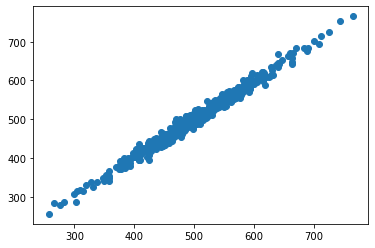

In [85]:
plt.scatter(output["ACTUAL_SPEND"], output["PREDICTED_SPEND"])

In [86]:
from sklearn import metrics

In [87]:
print('MAE:', metrics.mean_absolute_error(output["ACTUAL_SPEND"], output["PREDICTED_SPEND"]))
print('MSE:', metrics.mean_squared_error(output["ACTUAL_SPEND"], output["PREDICTED_SPEND"]))
print('RMSE:', np.sqrt(metrics.mean_squared_error(output["ACTUAL_SPEND"], output["PREDICTED_SPEND"])))

MAE: 7.895387697169229
MSE: 98.73987752129229
RMSE: 9.936794126945184


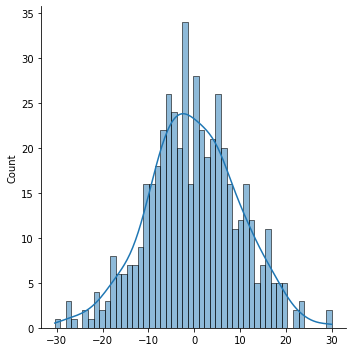

In [88]:
sns.displot((output["ACTUAL_SPEND"]- output["PREDICTED_SPEND"]),bins=50, kde=True);

In [89]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Avg. Session Length,25.981550
Time on App,38.590159
Time on Website,0.190405
Length of Membership,61.279097


### Conclusion
Time spent on the app and Length of Membership are most important factors driving customer spend. The retailer should focus its efforts on increasing stickiness to its app and enhance its loyalty programs.